In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import h5py
import os

%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import sys
sys.path.append('/reg/neh/home/qiaoshen/GitHub/loki/src/utils/')
from postproc_helper import *


from scipy.interpolate import interp1d
from scipy.signal import find_peaks_cwt

from scipy.optimize import curve_fit

import matplotlib as mpl

import matplotlib as mpl
mpl.rcParams['font.size']=16
mpl.rcParams['font.serif'] = "Bitstream Vera Serif"
mpl.rcParams['font.family'] = "serif"

from matplotlib.gridspec import GridSpec

In [2]:
def make_elbow_plot( data, max_nclust=12,):
    """data is Nexample x Nfeatures """
    elbow_plot = []
    max_nclust = 12
    for i in xrange( 1, max_nclust+1):
        print("TRygin kmeans with %d clusters (up to %d)"%(i, max_nclust))
        kmeans = KMeans( n_clusters=i)
        kmeans.fit( data)
        elbow_plot.append( kmeans.score(data))
    plt.xlabel('# of clusters')
    plt.ylabel('how good is the clustering')
    plt.plot( np.arange( 1, max_nclust+1), elbow_plot, '.')

#     plt.show()
    return np.arange( 1, max_nclust+1), elbow_plot

def convert_shots_to_outliers(shots, mask):
    outlier_shots=np.zeros_like(shots)
    for idx,test_shot in enumerate(shots):
        masked_average = np.sum(test_shot*mask)/mask.sum()
        masked_std = np.sqrt(np.sum( (test_shot- masked_average)**2*mask)/mask.sum() )

        outliers=test_shot>masked_average+masked_std*1
        outlier_shots[idx]=test_shot*outliers
        
        
    return outlier_shots


def find_highest_two_peaks( smoothed_shots):
    peak_positions_in_pixels=np.zeros( (smoothed_shots.shape[0],2) )
    for shot_idx in range(smoothed_shots.shape[0]):
        peak_pos=find_peaks_cwt(smoothed_shots[shot_idx], range(1,11))
        peak_values=smoothed_shots[shot_idx,peak_pos]
        max_2 = np.argsort(peak_values)[-2:]
        
        peak_positions_in_pixels[shot_idx]=np.where(mask)[0][peak_pos[max_2] ]

    return peak_positions_in_pixels.astype(int)

def smooth_unmasked_area(shots, mask):
    smoothed_shots=np.zeros( (shots.shape[0],np.where(mask)[0].shape[-1]) )
    for shot_idx in range(shots.shape[0]):
        try:
            smoothed_shots[shot_idx]=smooth(shots[shot_idx][mask],window_size=11)
        except ValueError:
            print shot_idx
            break
    return smoothed_shots

def lorentz_func(x, A, sigma,mu):
    return A*sigma**2/(sigma**2 + (x-mu)**2)

In [3]:
run_num=18
PT_dir = '/reg/d/psdm/cxi/cxilp6715/results/combined_tables/finer_q/'
f_PI=h5py.File(os.path.join(PT_dir,'run%d.tbl'%run_num),'r')
print f_PI.keys()
mask = f_PI['polar_mask_binned'].value
mask = (mask==mask.max())
shots = f_PI['polar_imgs'].value[:20000,:5,:]*mask[:5]
full_shots = f_PI['polar_imgs'].value[:20000,:,:]*mask

run_num=11
PT_dir = '/reg/d/psdm/cxi/cxilp6715/results/combined_tables/finer_q/'
f_PI=h5py.File(os.path.join(PT_dir,'run%d.tbl'%run_num),'r')
print f_PI.keys()
mask2 = mask.copy()
# mask2 = f_PI['polar_mask_binned'].value
# mask2 = (mask2==mask2.max())
shots2 = f_PI['polar_imgs'].value[:20000,:5,:]*mask[:5]

[u'ebeam', u'event_time', u'evr', u'fiducials', u'gas_detector', u'phase_cav', u'polar_imgs', u'polar_mask', u'polar_mask_binned', u'polar_params', u'radial_profs']
[u'ebeam', u'event_time', u'evr', u'fiducials', u'gas_detector', u'phase_cav', u'polar_imgs', u'polar_params', u'radial_profs']


In [4]:
ave_shots = shots.sum(1)
ave_shots2 = shots2.sum(1)
norm_shots = ave_shots/ave_shots.mean(-1)[:,None]
norm_shots2 = ave_shots2/ave_shots2.mean(-1)[:,None]

# plt.plot(ave_shots.mean(0))

In [5]:
pca=PCA(n_components=10)
new_shots=pca.fit_transform(norm_shots)
components = pca.components_

kmeans = KMeans( n_clusters=10)
kmeans.fit( new_shots)

pca2=PCA(n_components=10)
new_shots2=pca2.fit_transform(norm_shots2)
components2 = pca.components_

kmeans2 = KMeans( n_clusters=3)
kmeans2.fit( new_shots2)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
pos1 = np.argmax(norm_shots[:,86:96],axis=-1)+86
pos2 = np.argmax(norm_shots[:,265:275],axis=-1)+265

pos1_2 = np.argmax(norm_shots2[:,90:100],axis=-1)+90
pos2_2 = np.argmax(norm_shots2[:,268:278],axis=-1)+268

dist = pos2-pos1
dist2 = pos2_2-pos1_2

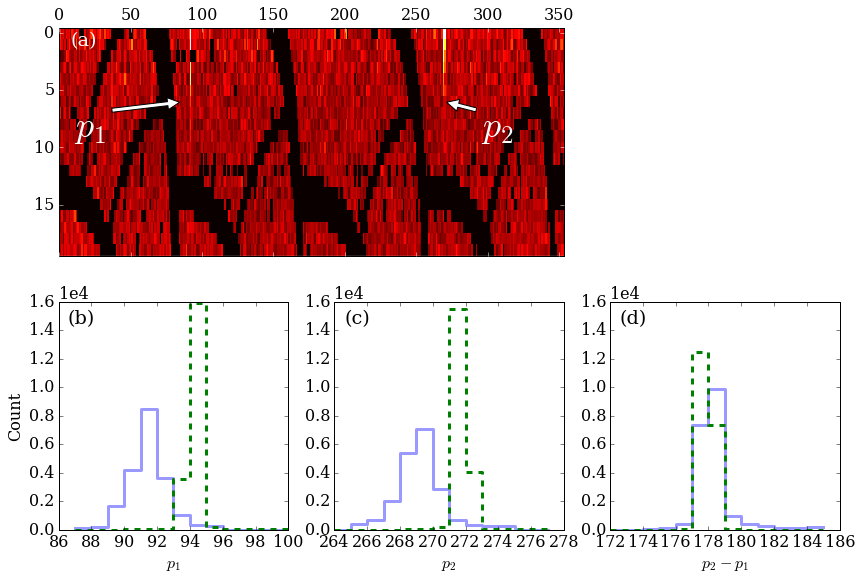

In [17]:

plt.figure(figsize=[14,9])
gs = GridSpec(2,3)
gs.update(wspace = 0.2)

ax = plt.subplot(gs[0,:2])
ax.set_title('(a)', x=0.05,y=0.9, color='white')
plt.imshow((full_shots[100]*mask)[:20], aspect='auto', interpolation='none'
           , cmap='hot',vmin=0,vmax=4e5)
ax.annotate('$p_1$', xy=(87, 6), xytext=(10, 9),color='white', 
            arrowprops=dict(facecolor='white', shrink=0.05),fontsize = 36
            )

ax.annotate('$p_2$', xy=(270, 6), xytext=(295, 9),color='white', 
            arrowprops=dict(facecolor='white', shrink=0.05),fontsize = 36
            )

ax.tick_params(labeltop=True,top=True, labelbottom=False, color='white')
##########################################
ax=plt.subplot(gs[1,0])
ax.set_title('(b)', x=0.1,y=0.88)
bins=np.arange(86,101,1)
hist1=np.histogram(pos1,bins=bins)
hist2=np.histogram(pos1_2,bins=bins)

plt.step(bins[1:],hist1[0], linewidth=3, alpha=0.4)
plt.step(bins[1:],hist2[0], linewidth=3, alpha=1, linestyle='--')
plt.xlabel('$p_1$')
ylab=plt.ylabel('Count')
# ylab.set_position((86,0.5))

plt.ylim(0,16000)
ax.ticklabel_format(style='sci',scilimits=[-1,1], axis='y')
#######################################
ax =plt.subplot(gs[1,1])
bins=np.arange(263,278,1)
hist1=np.histogram(pos2,bins=bins)
hist2=np.histogram(pos2_2,bins=bins)

plt.step(bins[1:],hist1[0], linewidth=3, alpha=0.4)
plt.step(bins[1:],hist2[0], linewidth=3, alpha=1., linestyle='--')
plt.ylim(0,16000)
plt.xlabel('$p_2$')
ax.set_title('(c)', x=0.1,y=0.88)
ax.ticklabel_format(style='sci',scilimits=[-1,1], axis='y')
########################################
ax =plt.subplot(gs[1,2])
ax.set_title('(d)', x=0.1,y=0.88)
bins=np.arange(171,186,1)

hist1=np.histogram(dist,bins=bins)
hist2=np.histogram(dist2,bins=bins)
plt.step(bins[1:],hist1[0], linewidth=3, alpha=0.4)
plt.step(bins[1:],hist2[0], linewidth=3, alpha=1., linestyle='--')
plt.xlabel('$p_2 - p_1$')
plt.ylim(0,16000)
ax.ticklabel_format(style='sci',scilimits=[-1,1], axis='y')

plt.savefig('streak_positions_hist.png',bbox_in_inches='tight')

In [53]:
np.where(kmeans.labels_==0)
a = range(0,norm_shots.shape[0])
a.remove(9346)
# a.remove(9342)
# a.remove(9344)
# a.remove(9343)

# norm_shots 9341,9342
inds=range(86,96)
inds.extend(range(264,274))
x = norm_shots[a][:,inds]
x.shape

(19999, 20)

In [54]:
np.where(kmeans.labels_==1)

(array([9346]),)

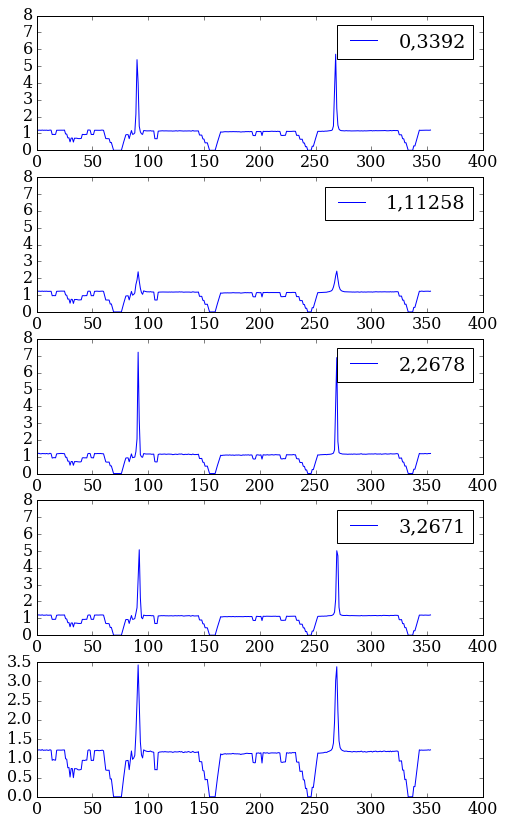

In [55]:
kmeans = KMeans( n_clusters=4)
kmeans.fit( x)

cluster_data=[]
for ll in range(kmeans.n_clusters):
    cluster_data.append(norm_shots[a][kmeans.labels_==ll])

plt.figure(figsize = [8,14])
for ii,cc in enumerate(cluster_data):
    plt.subplot(kmeans.n_clusters+1,1,ii+1)
    plt.plot(cc.mean(0),label="%d,%d"%(ii, cc.shape[0]) )
    plt.legend()
    plt.ylim(0,8)
plt.subplot(kmeans.n_clusters+1,1,kmeans.n_clusters+1)
plt.plot(norm_shots.mean(0))
# plt.xlim(260,280)
# plt.xlim(90,100)

(85, 98)

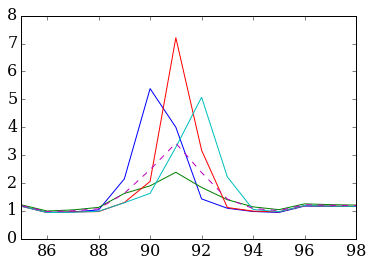

In [56]:
for ii in range(kmeans.n_clusters):
#     plt.subplot(6,1,ii+1)
    if cluster_data[ii].shape[0]>100:
        plt.plot(cluster_data[ii].mean(0),label="%d,%d"%(ii, cc.shape[0]) )
#     plt.legend()
# plt.subplot(6,1,6)
plt.plot(norm_shots.mean(0),'--')
# plt.xlim(260,280)
plt.xlim(85,98)

TRygin kmeans with 1 clusters (up to 12)
TRygin kmeans with 2 clusters (up to 12)
TRygin kmeans with 3 clusters (up to 12)
TRygin kmeans with 4 clusters (up to 12)
TRygin kmeans with 5 clusters (up to 12)
TRygin kmeans with 6 clusters (up to 12)
TRygin kmeans with 7 clusters (up to 12)
TRygin kmeans with 8 clusters (up to 12)
TRygin kmeans with 9 clusters (up to 12)
TRygin kmeans with 10 clusters (up to 12)
TRygin kmeans with 11 clusters (up to 12)
TRygin kmeans with 12 clusters (up to 12)


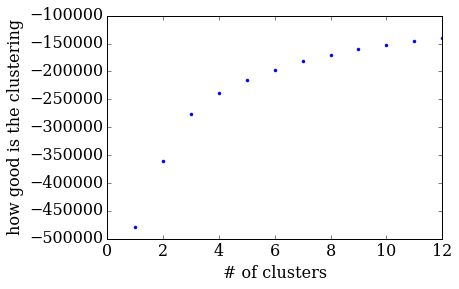

In [57]:
n_cluster, elbow=make_elbow_plot(x)

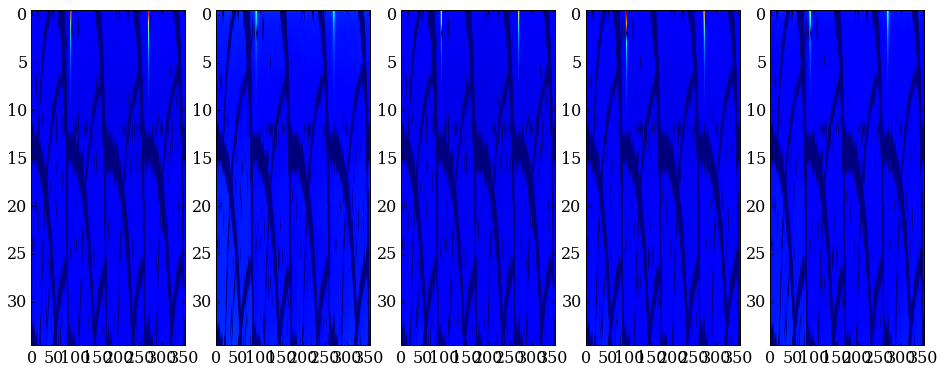

In [58]:
plt.figure(figsize=[16,6])
for ll in range(kmeans.n_clusters):
    plt.subplot(1,kmeans.n_clusters+1,ll+1)
    plt.imshow( full_shots[a][kmeans.labels_==ll].mean(0), aspect='auto',
              vmin=0,vmax=7.2e5)
    
plt.subplot(1,kmeans.n_clusters+1,kmeans.n_clusters+1)
plt.imshow( full_shots.mean(0), aspect='auto',vmin=0,vmax=7.2e5)
# plt.colorbar()

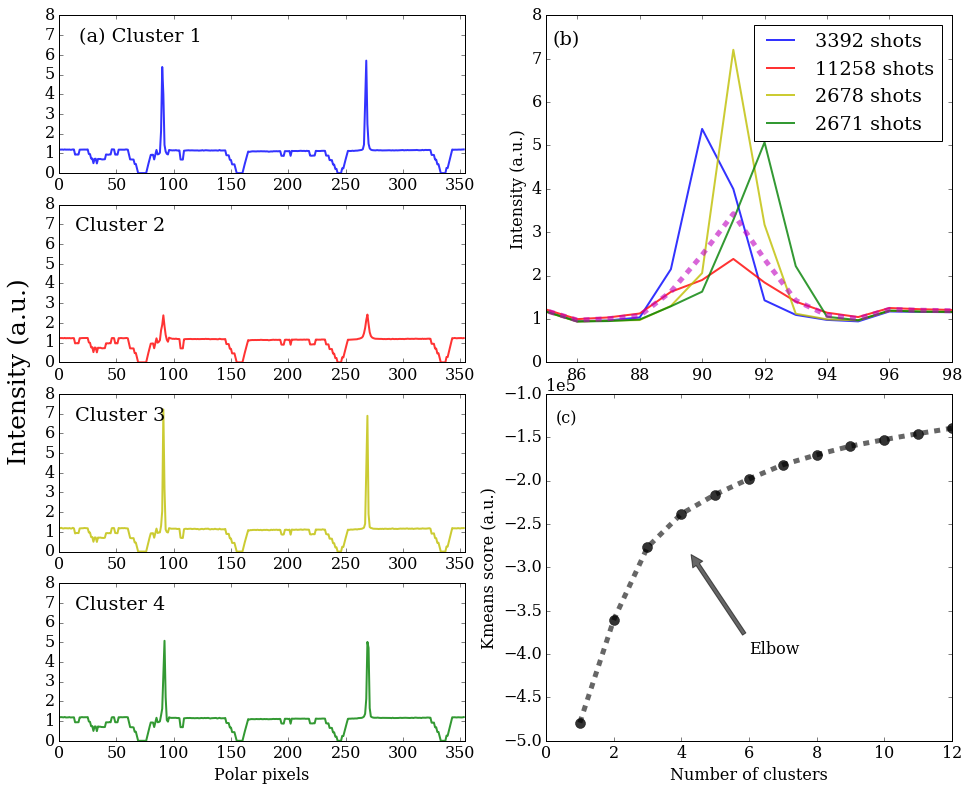

In [63]:
gs = mpl.gridspec.GridSpec(kmeans.n_clusters,2)
fig=plt.figure(figsize = [16,13])
fig.text(s='Intensity (a.u.)', x=0.08,y = 0.6,
         rotation='vertical', fontsize = 25)
colors = ['b','r','y','g']
gs.update(wspace = 0.2)
for ii,cc in enumerate(cluster_data):
    ax= plt.subplot(gs[ii,0])
    plt.plot(cc.mean(0),label="%d,%d"%(ii, cc.shape[0]), color=colors[ii],
            linewidth = 2, alpha=0.8)
    if ii == 0:
        ax.set_title('(a) Cluster %d'%(ii+1), x = 0.2, y = 0.8)
    else:
        ax.set_title('Cluster %d'%(ii+1), x = 0.15, y = 0.8)
    
    plt.ylim(0,8)
    plt.xlim(0,354)
plt.xlabel('Polar pixels')

############################################
    
ax = plt.subplot(gs[:2,1])  
ax.set_title('(b)',x = 0.05, y =0.9)
for ii in range(kmeans.n_clusters):

    if cluster_data[ii].shape[0]>100:
        plt.plot(cluster_data[ii].mean(0)
                 ,label="%d shots"%(cluster_data[ii].shape[0]),color=colors[ii] ,
                 linewidth = 2, alpha=0.8)
        

plt.plot(norm_shots.mean(0),linewidth = 5, alpha=0.6
         , color = 'm', linestyle='--')
plt.legend()
plt.xlabel('$p_1$', fontsize = 16)
plt.ylabel('Intensity (a.u.)')
# plt.xlim(260,280)
plt.xlim(85,98)
################################################
ax = plt.subplot(gs[2:,1])
ax.set_title('(c)',x = 0.05, y =0.9, fontsize = 16)
plt.plot(n_cluster, elbow,'k.', markersize = 20, alpha = 0.8)
plt.plot(n_cluster, elbow,'k--',linewidth = 5, alpha = 0.6)
ax.ticklabel_format(style='sci', scilimits=[-1,1], axis='y')
plt.annotate(s="Elbow", xytext = (6,-4e5,),
             xy=(4.2,-2.8e5),fontsize = 16,
             arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.6))
plt.xlabel('Number of clusters')
plt.ylabel('Kmeans score (a.u.)')

# ax.ticklabel_format(style='sci',scilimits=[-1,1], axis='y')
# plt.savefig('streak cluster_kmeans.png',bbox_in_inches='tight')